# Testing how terrible chat is at saving us from outr time constraint

## Plane creation

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np

# Basic geometry parameters
span = 42  # Total span
root_chord = 5
taper_ratio = 0.4
tip_chord = root_chord * taper_ratio
half_span = span / 2
n_propulsors_per_wing = 4

# Define the wing
wing = asb.Wing(
    name="Main Wing",
    symmetric=True,
    xsecs=[
        asb.WingXSec(
            xyz_le=[0,0,0],
            chord=root_chord,
            airfoil=asb.Airfoil("naca2412")
        ),
        asb.WingXSec(
            xyz_le=[0,half_span,0],
            chord=tip_chord,
            airfoil=asb.Airfoil("naca2412")
        )
    ]
)

# Define propulsor positions along the wing span
# Choose evenly spaced positions on each side, avoiding root/tip
y_positions_right = np.linspace(half_span * 0.15, half_span * 0.85, n_propulsors_per_wing)
y_positions = np.concatenate([-y_positions_right[::-1], y_positions_right])  # Left and right

# Define the thrust magnitude for each propulsor
def constant_thrust(thrust_value):
    return lambda op_point: np.array([thrust_value, 0, 0])  # Thrust in +X (forward)

# Create propulsors
thrust_per_engine = 5000  # N (arbitrary example value)
propulsors = []

for i, y in enumerate(y_positions):
    propulsors.append(
        asb.Propulsor(
            name=f"Engine_{i+1}",
            xyz_c=np.array([-2, y, 0]),  # 2 m ahead of wing LE, spanwise y, z = 0
            xyz_normal=[-1,0,0]
        )
    )

# Define the airplane with wing and propulsors
airplane = asb.Airplane(
    name="Custom 8-Engine Aircraft",
    wings=[wing],
    propulsors=propulsors
)

airplane.draw()

Widget(value='<iframe src="http://localhost:63406/index.html?ui=P_0x1935a462cf0_0&reconnect=auto" class="pyvis…

PolyData,Information
N Cells,290
N Points,292
N Strips,0
X Bounds,"-3.856e-04, 5.000e+00"
Y Bounds,"-2.100e+01, 2.100e+01"
Z Bounds,"-2.115e-01, 3.955e-01"
N Arrays,0


In [2]:
#basic vlm
def run_vlm_force_analysis(
    airplane: asb.Airplane,
    op_point: asb.OperatingPoint
) -> np.ndarray:
    """
    Runs a VLM analysis and returns aerodynamic forces at each node of the wing mesh.

    Args:
        airplane (asb.Airplane): The airplane object.
        op_point (asb.OperatingPoint): Operating conditions.

    Returns:
        np.ndarray: An (n_panels, 3) array of aerodynamic force vectors [Fx, Fy, Fz] at each panel control point.
    """
    # Set up the VLM analysis
    vlm = asb.VortexLatticeMethod(
        airplane=airplane,
        op_point=op_point,
        spanwise_resolution=20,
        chordwise_resolution=5
    )

    # Run the VLM analysis
    sol = vlm.run()

    # Get forces at each panel
    forces = sol["F_g"]  # Shape: (n_spanwise, n_chordwise, 3)
    moments = sol["M_g"] 

    return forces, moments, vlm

# Define freestream conditions
op_point = asb.OperatingPoint(
    velocity=70,      # m/s
    alpha=5,          # degrees
    beta=0,           # degrees
    atmosphere=asb.Atmosphere(6000)
)

# Run VLM force analysis
forces, moments, vlm = run_vlm_force_analysis(airplane, op_point)

# Inspect result
print("Forces total:")
print(forces)

Forces total:
[-1.03803109e+04 -6.30051566e-14  1.45295931e+05]


## Now, the forces have to be interpolated

### An oversimplified wing geometry

In [3]:
import aerosandbox.numpy as np

def generate_spanwise_line_at_chord_fraction(wing: asb.Wing, chord_fraction: float, spacing: float) -> np.ndarray:
    """
    Generates a spanwise line of points following a constant chordwise fraction across the wing.

    Args:
        wing (asb.Wing): The wing geometry (assumed symmetric).
        chord_fraction (float): Fraction of chord from LE (0 = LE, 1 = TE).
        spacing (float): Desired spacing in meters between points along the span.

    Returns:
        np.ndarray: Array of shape (N, 3) with [x, y, z] points.
    """
    root_xsec = wing.xsecs[0]
    tip_xsec = wing.xsecs[1]

    half_span = abs(tip_xsec.xyz_le[1] - root_xsec.xyz_le[1])
    n_points = max(2, int(np.ceil(half_span / spacing)) + 1)
    y_vals = np.linspace(0, half_span, n_points)

    points = []
    for y in y_vals:
        # Interpolate leading edge and chord along span
        x_le = np.interp(y, [0, half_span], [root_xsec.xyz_le[0], tip_xsec.xyz_le[0]])
        y_le = np.interp(y, [0, half_span], [root_xsec.xyz_le[1], tip_xsec.xyz_le[1]])
        z_le = np.interp(y, [0, half_span], [root_xsec.xyz_le[2], tip_xsec.xyz_le[2]])
        chord = np.interp(y, [0, half_span], [root_xsec.chord, tip_xsec.chord])

        x = x_le + chord_fraction * chord
        y = y_le
        z = z_le  # Assuming flat (zero twist/camber)

        points.append([x, y, z])

        if y != 0:  # Symmetric side
            points.append([x, -y, z])

    return np.array(points)


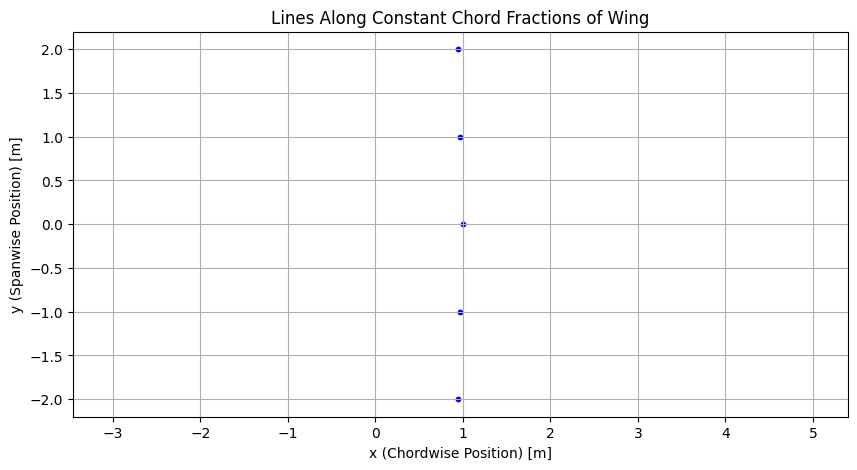

In [4]:
import matplotlib.pyplot as plt
import numpy as onp  # For compatibility with matplotlib

# Chord fractions to evaluate
chord_fractions = [0.2, 0.25, 0.3, 0.34, 0.4, 0.47, 0.55, 0.6]

# Spacing along span (m)
spacing = 1.0

# Container for all points
all_points = []

for frac in chord_fractions:
    points = generate_spanwise_line_at_chord_fraction(wing=wing, chord_fraction=frac, spacing=spacing)
    all_points.append(points)

# Combine into one (N, 3) array
combined_points = onp.vstack(all_points)

# Plot x vs y
plt.figure(figsize=(10, 5))
plt.scatter(combined_points[:5, 0], combined_points[:5, 1], s=10, c='blue')
plt.xlabel("x (Chordwise Position) [m]")
plt.ylabel("y (Spanwise Position) [m]")
plt.title("Lines Along Constant Chord Fractions of Wing")
plt.grid(True)
plt.axis('equal')
plt.show()


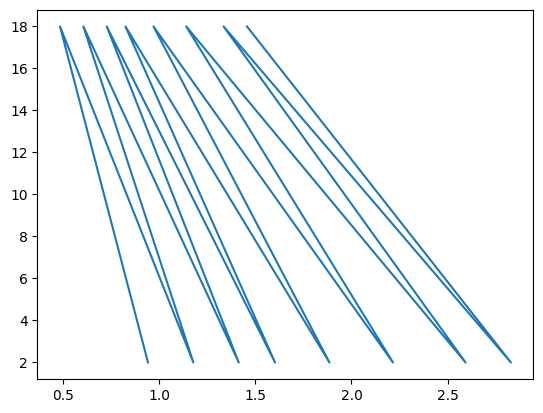

In [5]:
"restricting the size of the structural mesh"
y_all = combined_points[:, 1]
include = (y_all <= 18) & (y_all >= 1.2) 
ncoords = combined_points[include]
plt.plot(ncoords.T[0], ncoords.T[1]) #shape 0 along the c, shape 12 along b

elements created


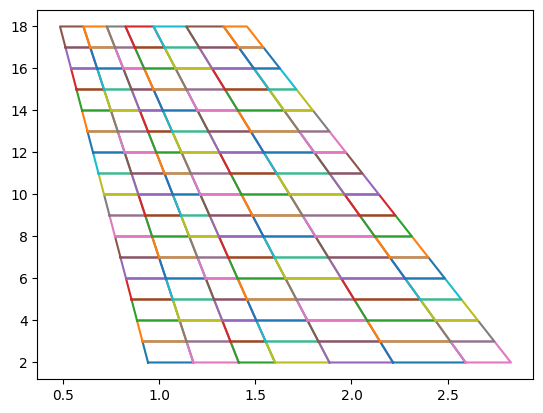

In [6]:
import numpy as np
from scipy.sparse.linalg import cg
from scipy.sparse import coo_matrix

from pyfe3d.shellprop_utils import isotropic_plate
from pyfe3d import Quad4, Quad4Data, Quad4Probe, INT, DOUBLE, DOF
"quad generation copypasta"

'''before ncoords definition'''
data = Quad4Data()
probe = Quad4Probe()

a = 3
b = 7
h = 1 # m

#to keep consistency with the generated points
nx=8
ny=int(ncoords.shape[0]/nx)

E = 200e9
nu = 0.3

'''after ncoords definition'''
x = ncoords[:, 0]
y = ncoords[:, 1]
z = ncoords[:, 2]
ncoords_flatten = ncoords.flatten()

nids = 1 + np.arange(ncoords.shape[0])
nid_pos = dict(zip(nids, np.arange(len(nids))))
nids_mesh = nids.reshape(8, ny)
n1s = nids_mesh[:-1, :-1].flatten()
n2s = nids_mesh[1:, :-1].flatten()
n3s = nids_mesh[1:, 1:].flatten()
n4s = nids_mesh[:-1, 1:].flatten()

num_elements = len(n1s)

KC0r = np.zeros(data.KC0_SPARSE_SIZE*num_elements, dtype=INT)
KC0c = np.zeros(data.KC0_SPARSE_SIZE*num_elements, dtype=INT)
KC0v = np.zeros(data.KC0_SPARSE_SIZE*num_elements, dtype=DOUBLE)
Mr = np.zeros(data.M_SPARSE_SIZE*num_elements, dtype=INT)
Mc = np.zeros(data.M_SPARSE_SIZE*num_elements, dtype=INT)
Mv = np.zeros(data.M_SPARSE_SIZE*num_elements, dtype=DOUBLE)
N = DOF*nx*ny

prop = isotropic_plate(thickness=h, E=E, nu=nu, calc_scf=True, rho=100) #not needed for smeard

quads = []
init_k_KC0 = 0
init_k_M = 0
for n1, n2, n3, n4 in zip(n1s, n2s, n3s, n4s):
    pos1 = nid_pos[n1]
    pos2 = nid_pos[n2]
    pos3 = nid_pos[n3]
    pos4 = nid_pos[n4]
    r1 = ncoords[pos1]
    r2 = ncoords[pos2]
    r3 = ncoords[pos3]
    normal = np.cross(r2 - r1, r3 - r2)[2]
    assert normal > 0
    quad = Quad4(probe)
    quad.n1 = n1 #@# connectring it to the global stiffness matrix
    quad.n2 = n2
    quad.n3 = n3
    quad.n4 = n4
    quad.c1 = DOF*nid_pos[n1]
    quad.c2 = DOF*nid_pos[n2]
    quad.c3 = DOF*nid_pos[n3]
    quad.c4 = DOF*nid_pos[n4]
    quad.init_k_KC0 = init_k_KC0
    quad.update_rotation_matrix(ncoords_flatten)
    quad.update_probe_xe(ncoords_flatten)
    quad.update_KC0(KC0r, KC0c, KC0v, prop) #matrix contribution, changing the matrices sent
    quad.update_M(Mr, Mc, Mv, prop)
    quads.append(quad)
    init_k_KC0 += data.KC0_SPARSE_SIZE
    init_k_M += data.M_SPARSE_SIZE

KC0 = coo_matrix((KC0v, (KC0r, KC0c)), shape=(N, N)).tocsc() #@# stiffness matrix in sparse format
M = coo_matrix((Mv, (Mr, Mc)), shape=(N,N)).tocsc()

print('elements created')
for quad in quads:
    poses = [nid_pos[nid] for nid in [quad.n1, quad.n2, quad.n3, quad.n4, quad.n1]]
    plt.plot(ncoords.T[0][poses], ncoords.T[1][poses])

Interior and boundary regions

In [7]:
check = np.isclose(y, min(y))
bk = np.zeros(N, dtype=bool)
for i in range(6):
    bk[i::DOF] = check
bu = ~bk
bu, bk

(array([False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

### Interpolation of the aerodynamic loads

In [8]:
'''Interpol from CRM_WING'''
from scipy.spatial import cKDTree

number_of_neighbors = 10

# x, y, z coordinates of each node, NOTE assuming same order for DOFs
vortex_valid = vlm.vortex_centers[:, 1] > ncoords[:, 1].min() # region represented by the FE model

tree = cKDTree(ncoords)
d, node_indices = tree.query(vlm.vortex_centers[vortex_valid], k=number_of_neighbors)

power = 2
weights = (1/d**power)/((1/d**power).sum(axis=1)[:, None])
assert np.allclose(weights.sum(axis=1), 1)
print('distances', d, d.min())

distances [[0.9258912  0.99232572 1.12998785 1.19690178 1.34199865 1.41122636
  1.51507864 1.58705916 1.65271635 1.76740551]
 [0.49720138 0.5823287  0.61846642 0.7026942  0.78884853 0.87153543
  0.94304809 1.02577682 1.1896697  1.27457095]
 [0.48606774 0.50432959 0.55242332 0.6040178  0.61948626 0.65374328
  0.72511662 0.75212321 0.77314342 0.83649331]
 [0.73647239 0.74438694 0.9120886  0.9340256  1.23542008 1.26451953
  1.53856505 1.56659449 1.60640161 1.71033592]
 [1.57232998 1.62848659 1.79549686 1.84887307 2.15812037 2.20145621
  2.20496061 2.37175067 2.47897275 2.51880122]
 [0.83423318 1.04400675 1.07000365 1.25152572 1.25778233 1.43048018
  1.44644918 1.49953821 1.60877803 1.61744693]
 [0.35183492 0.50222113 0.69189995 0.73381464 0.82810581 0.85471001
  0.9682584  1.10189339 1.10720737 1.30794661]
 [0.33182003 0.36412397 0.49377118 0.6273967  0.64140153 0.70953034
  0.75260327 0.78259562 0.82719794 0.84210063]
 [0.62757915 0.82818612 0.84307136 0.98725655 1.16495418 1.27053695
  

In [9]:
v = vortex_valid.sum()*3
W = np.zeros((N, v))
print(W.shape, node_indices.shape, weights.shape)

(816, 240) (80, 10) (80, 10)


In [10]:
W *= 0
for j in range(number_of_neighbors):
    for i, node_index in enumerate(node_indices[:, j]):
        W[DOF*node_index + 0, i*3 + 0] += weights[i, j]
        W[DOF*node_index + 1, i*3 + 1] += weights[i, j]
        W[DOF*node_index + 2, i*3 + 2] += weights[i, j]
assert np.allclose(W.sum(axis=0), 1.)

print(vlm.forces_geometry[vortex_valid].shape)
print(vlm.forces_geometry[:3])
Fv = vlm.forces_geometry[vortex_valid].flatten()
print(Fv[:9])
Fext = W @ Fv

(80, 3)
[[-2.74542164e+01 -3.33546159e-02  1.24303978e+02]
 [-1.30163887e+01 -1.23490354e-03  1.75452846e+02]
 [-8.46499992e+00 -3.69809917e-02  1.76247100e+02]]
[-2.25231771e+02 -2.85381480e-01  9.95560009e+02 -9.33418086e+01
  2.32800773e-01  1.40312089e+03 -3.24041306e+01  1.84319055e+00
  1.41229350e+03]


Checks

In [11]:
print('Fx.sum', Fext[0::DOF].sum(), Fv[0::3].sum())
print('Fy.sum', Fext[1::DOF].sum(), Fv[1::3].sum())
print('Fz.sum', Fext[2::DOF].sum(), Fv[2::3].sum())
Mx_v = (vlm.vortex_centers[vortex_valid][:, 1]*Fv[2::3]).sum()
Mx_u = (ncoords[:, 1]*Fext[2::DOF]).sum()
print(Mx_v, Mx_u, ' error:', Mx_u/Mx_v - 1)

assert np.isclose(Fext[0::DOF].sum(), Fv[0::3].sum())
assert np.isclose(Fext[1::DOF].sum(), Fv[1::3].sum())
assert np.isclose(Fext[2::DOF].sum(), Fv[2::3].sum())

Fx.sum -4544.300717003933 -4544.300717003933
Fy.sum 67.11681683882202 67.11681683882202
Fz.sum 63382.961072941696 63382.961072941696
638450.8781287547 631247.3171719541  error: -0.011282874225051809


In [12]:
import pyvista as pv

centers = []
vecs = []
for node_i, xyz in enumerate(ncoords):
    start_point = xyz 
    vec = Fext[DOF*node_i:DOF*node_i+3]
    if np.isclose(np.linalg.norm(vec), 0):
        continue
    centers.append(start_point)
    vecs.append(vec)
    
centers = np.asarray(centers)
vecs = np.asarray(vecs)
vecs /= np.max(np.linalg.norm(vecs, axis=1))

plotter = pv.Plotter()
plotter.add_arrows(centers, vecs, mag=1)
plotter.show()

Widget(value='<iframe src="http://localhost:63406/index.html?ui=P_0x1936afa78f0_1&reconnect=auto" class="pyvis…

## FEM solution

In [13]:
from scipy.sparse.linalg import spsolve

Kuu = KC0[:, bu][bu, :]
fu = Fext[bu]
uu = spsolve(Kuu, fu)
u=np.zeros(N)
u[bu] = uu

displ_vec = np.zeros_like(ncoords)
for i in range(3):
    displ_vec[:, i] = u[i::DOF]
total_displ = np.sqrt(displ_vec[:, 0]**2 + displ_vec[:, 1]**2 + displ_vec[:, 2]**2)

Adapting the function definition to us not having the model class

In [14]:
def plot3d_pyvista(ncoords, nid_pos, quads, displ_vec=None, contour_vec=None,
        contour_label='vec', contour_colorscale='coolwarm', background='white'):
    """Plot results using pyvista
 
    Parameters
    ----------
    displ_vec : array-like
        Nodal displacements to be applied to the nodal coordinates in order to visualize the deformed model.
    contour_vec : array-like
        Nodal or element-wise output to be displayed as a contour plot on top of the undeformed mesh.
        For nodal output, the function expects the order of attr:`.ModelPyFE3D.ncoords`.
        For element-wise output, the function expects the element outputs in the following order of elements:
 
        - :attr:`ModelPyFE3D.list_Quad4R`
        - :attr:`ModelPyFE3D.list_Tria3R`
 
    contour_label : str
        Name of contour being displayed.
    contour_colorscale : str
        Name of the colorscale.
 
    Returns
    -------
    plotter : `pyvista.Plotter` object
        A plotter object that is ready to be modified, or shown with ``plotter.show()``.
 
    """
    import pyvista as pv
 
    # NOTE needs ipygany and pythreejs packages (pip install pyvista pythreejs ipygany --upgrade)
 
    intensitymode = None
    if contour_vec is not None:
        if len(contour_vec) == len(ncoords):
            intensitymode = 'vertex'
        elif len(contour_vec) == len(quads):
            intensitymode = 'cell'
        else:
            raise RuntimeError('coutour_vec must be either a nodal or element output')
 
    plotter = pv.Plotter(off_screen=False)
    faces_quad = []
    for q in quads:
        faces_quad.append([4, nid_pos[q.n1], nid_pos[q.n2], nid_pos[q.n3], nid_pos[q.n4]])
    faces_quad = np.array(faces_quad)
    quad_plot = pv.PolyData(ncoords, faces_quad)
    if contour_vec is not None:
        if intensitymode == 'vertex':
            quad_plot[contour_label] = contour_vec
        else:
            quad_plot[contour_label] = contour_vec[:len(quads)]
 
        plotter.add_mesh(quad_plot, scalars=contour_label,
                cmap=contour_colorscale, edge_color='black', show_edges=True,
                line_width=1.)
    else:
        plotter.add_mesh(quad_plot, edge_color='black', show_edges=True,
                line_width=1.)
        
    if displ_vec is not None:
        quad_plot = pv.PolyData(ncoords + displ_vec, faces_quad)
        plotter.add_mesh(quad_plot, edge_color='red', show_edges=True,
                line_width=1., opacity=0.5)
        
    plotter.set_background(background)
    plotter.parallel_projection = False
    return plotter

In [15]:
plotter = plot3d_pyvista(ncoords, nid_pos, quads,
                         displ_vec=displ_vec, 
                         contour_vec=total_displ, 
                         contour_label='displacement [mm]', 
                         background='gray')
plotter.show()

Widget(value='<iframe src="http://localhost:63406/index.html?ui=P_0x1936b171340_2&reconnect=auto" class="pyvis…

## Flutter

### Interpolation back to aerodynamic loads

In [16]:
number_of_neighbors2 = 2
airfoil_ys = [0, half_span]
airfoil_xs = [0, 0]
z_root = 0

#TODO what is this
var_hd0 = 0
var_hd1 = 1
var_twist0 = 5.2
var_twist1 = 5.2

p = np.array([var_hd0, var_hd1, var_twist0, var_twist1])

heave_displs = p[:2]
# twists = p[4:] NOTE ignoring twists for now
airfoil_coords = np.vstack((airfoil_xs, airfoil_ys, z_root+heave_displs)).T
print(airfoil_coords)
tree = cKDTree(ncoords)
nodal_coords = ncoords # x, y, z coordinates of each node, NOTE assuming same order for DOFs
d, node_indices = tree.query(airfoil_coords, k=number_of_neighbors2)
power = 2
weights2 = (1/d**power)/((1/d**power).sum(axis=1)[:, None])
assert np.allclose(weights2.sum(axis=1), 1)
print('distances', d, d.min(), d.max())

[[ 0.  0.  0.]
 [ 0. 21.  1.]]
distances [[2.2111037  2.32142857]
 [3.19936218 3.22003454]] 2.211103704450955 3.22003454158175


In [17]:
from scipy.sparse import csc_matrix

W_u_to_p = np.zeros((len(heave_displs)*3, N))
print(W_u_to_p.shape, node_indices.shape, weights2.shape)

for j in range(number_of_neighbors2):
    for i, node_index in enumerate(node_indices):
        W_u_to_p[i*3 + 0, DOF*node_index + 0] = weights2[i, j]
        W_u_to_p[i*3 + 1, DOF*node_index + 1] = weights2[i, j]
        W_u_to_p[i*3 + 2, DOF*node_index + 2] = weights2[i, j]
    
W_u_to_p = csc_matrix(W_u_to_p)

(6, 816) (2, 2) (2, 2)


Checks - airfoil heave displs.

In [18]:
from scipy.sparse.linalg import spsolve

Fext = W @ vlm.forces_geometry[vortex_valid].flatten()

u = np.zeros(N)
uu = spsolve(Kuu, Fext[bu])
u[bu] = uu

displ_vec = np.zeros_like(nodal_coords)
for i in range(3):
    displ_vec[:, i] = u[i::DOF]
total_displ = np.sqrt(displ_vec[:, 0]**2 + displ_vec[:, 1]**2 + displ_vec[:, 2]**2)

pdispl = W_u_to_p @ u

print(pdispl)

for node_index in node_indices.flatten():
    print(nodal_coords[node_index], u[0::DOF][node_index], u[1::DOF][node_index], u[2::DOF][node_index])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.65084766e-05
 -2.55167681e-06  1.16603090e-03]
[0.94285714 2.         0.        ] 0.0 0.0 0.0
[1.17857143 2.         0.        ] 0.0 0.0 0.0
[ 0.48571429 18.          0.        ] -2.6680403513779806e-05 -2.719825273592115e-06 0.0011739576474339346
[ 0.60714286 18.          0.        ] -2.6680220114441284e-05 -2.4166096984893785e-06 0.001173221218928656


### Aerodynamic Matrix

In [72]:
def calc_dFv_dp(op_pt:asb.OperatingPoint, airplane:asb.Airplane):
    epsilon = 0.01
    dFv_dp = np.zeros((v, len(heave_displs)*3))
    vlm = asb.VortexLatticeMethod(
        airplane,
        op_pt
    )
    vlm.run()
    for i in range(1): #we have only 2 cross sections TODO how much dow we need to observe the flutter
        p_DOF = 3*(i + 1) + 2 # heave DOF starting at second airfoil
        p2 = p.copy()
        p2[i+1] += epsilon

        wing2 = asb.Wing(
        name="Main Wing",
        symmetric=True,
        xsecs=[
            asb.WingXSec(
                xyz_le=[0,0,p2[0]],
                chord=root_chord,
                airfoil=asb.Airfoil("naca2412")
            ),
            asb.WingXSec(
                xyz_le=[0,half_span,p2[1]],
                chord=tip_chord,
                airfoil=asb.Airfoil("naca2412")
            )
            ]
        )

        vlm2 = asb.VortexLatticeMethod(
            airplane=asb.Airplane(
                name="AIAA dummy plane",
                xyz_ref=[0, 0, 0],
                wings=[wing2],
            ),
            op_point=op_pt
        )
        vlm2.run()
        Fv2 = vlm2.forces_geometry[vortex_valid].flatten()
        dFv_dp[:, p_DOF] += (Fv2 - Fv)/epsilon
    dFv_dp = csc_matrix(dFv_dp)
    return vlm, dFv_dp


vlm, dFv_dp = calc_dFv_dp(op_point, airplane)
KA = W @ dFv_dp @ W_u_to_p
print(KA.shape)

print(vlm.op_point.dynamic_pressure(),
      1/2*vlm.op_point.velocity**2*vlm.op_point.atmosphere.density())

(816, 816)
1620.9690031275532 1620.9690031275532


### Concluding the solution

In [92]:
from scipy.sparse.linalg import eigs
from scipy.linalg import eig
import matplotlib.pyplot as plt

Muu = M[bu, :][:, bu]

velocities = np.linspace(1, 60, 15)
omegans = []
for velocity in velocities:
    print('velocity [m/s]', velocity)
    op_pt = asb.OperatingPoint(
    velocity=velocity,      # m/s
    alpha=5,          # degrees
    beta=0,           # degrees
    atmosphere=asb.Atmosphere(6000)
)
    #KA *= 1/2*velocity**2*vlm.op_point.atmosphere.density()
    vlm, dFv_dp = calc_dFv_dp(op_pt, airplane)
    KA = W @ dFv_dp @ W_u_to_p
    KAuu = KA[bu, :][:, bu]
    k = 2
    tol = 0
    eigvals, peigvecs = eigs(A=Kuu - KAuu, M=Muu, k=k, which='LM', tol=tol, sigma=-1.)
    omegan = np.sqrt(eigvals)
    omegans.append(omegan)
    print('    natural frequencies [rad/s]', omegan)

velocity [m/s] 1.0
    natural frequencies [rad/s] [103.8058718 +0.j 169.70606805+0.j]
velocity [m/s] 5.214285714285714
    natural frequencies [rad/s] [103.77663603+0.j 169.70606805+0.j]
velocity [m/s] 9.428571428571429
    natural frequencies [rad/s] [103.70771453+0.j 169.70606805+0.j]
velocity [m/s] 13.642857142857142
    natural frequencies [rad/s] [103.59902804+0.j 169.70606805+0.j]
velocity [m/s] 17.857142857142858
    natural frequencies [rad/s] [103.45045115+0.j 169.70606805+0.j]
velocity [m/s] 22.071428571428573
    natural frequencies [rad/s] [103.26181157+0.j 169.70606805+0.j]
velocity [m/s] 26.285714285714285
    natural frequencies [rad/s] [103.03288911+0.j 169.70606805+0.j]
velocity [m/s] 30.5
    natural frequencies [rad/s] [102.76341439+0.j 169.70606805+0.j]
velocity [m/s] 34.714285714285715
    natural frequencies [rad/s] [102.45306723+0.j 169.70606805+0.j]
velocity [m/s] 38.92857142857143
    natural frequencies [rad/s] [102.10147469+0.j 169.70606805+0.j]
velocity [m/

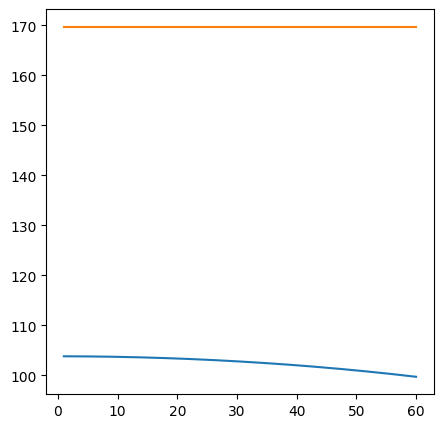

In [93]:
plt.figure(figsize=(5,5))
plt.plot(velocities, omegans)

In [94]:
from scipy.sparse.linalg import spsolve

velocity = 40 # [m/s]

vlm, dFv_dp = calc_dFv_dp(asb.OperatingPoint(
    velocity=velocity,      # m/s
    alpha=5,          # degrees
    beta=0,           # degrees
    atmosphere=asb.Atmosphere(6000)
), airplane)

KA = W @ dFv_dp @ W_u_to_p
KAuu = KA[bu, :][:, bu]

Fext = W @ vlm.forces_geometry[vortex_valid].flatten()

u = np.zeros(N)

velocity = 40
uu = spsolve(Kuu - KAuu, Fext[bu])
u[bu] = uu

scale = 1e6
displ_vec = np.zeros_like(nodal_coords)
for i in range(3):
    displ_vec[:, i] = scale*u[i::DOF]
total_displ = np.sqrt(displ_vec[:, 0]**2 + displ_vec[:, 1]**2 + displ_vec[:, 2]**2)

C:\Users\marri\AppData\Local\Temp\ipykernel_29988\799748601.py:20: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  uu = spsolve(Kuu - KAuu, Fext[bu])


In [86]:
plot3d_pyvista(ncoords, nid_pos, quads, displ_vec=displ_vec, contour_vec=total_displ, contour_label='displacement [mm]', background='gray').show()

Widget(value='<iframe src="http://localhost:62349/index.html?ui=P_0x140260a2810_11&reconnect=auto" class="pyvi…